In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import optimize
from scipy import stats
from scipy.special import erfc
from sklearn.model_selection import train_test_split
from scipy.stats import f

In [2]:
#data = np.genfromtxt('Phisher.csv', delimiter=',', skip_header=1)
data = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/Phisher.csv", sep=",", header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
0,0.781760,2.561364,2.892164e+00,0.033846,1.762401,0.114926,7.751423e-04,2.410102e+00,6.950226e+00,0.575746,0.864406,0.011821,0.014574,0.098604,5.943600e+00,0.568681,4.865012,0.000013,6.671908e-01,0.000670,5.024963e-03,7.333897e-02,2.860700,0.023607,8.056505e-01,0.021902,1.277094,0.665304,2.978723,0.158430,7.842911e-01,0.001222,3.019749e+00,1.868289,4.230919e-01,0.709703,1.142213e-05,3.021740e-01,6.807384e+00,0.075765,...,0.162989,0.002184,0.015844,1.259139,0.115320,1.482087,0.027750,5.262078e+00,1.349439e-01,0.009626,1.033021e+00,0.003955,0.226027,0.039575,8.391832,2.795828e-02,0.077144,1.039050e-02,1.973490e+00,1.354706,6.791477e+00,1.108556e+00,2.121029e+00,0.124207,2.196628e-04,1.204363,4.019070,4.473807e-02,3.056679,3.631391e-01,2.561108e+00,6.643192,6.191190e+00,0.443505,4.341194,0.977696,2.605645e-01,2.021747e-01,4.643132e-04,2.823225e+00
1,0.888409,2.832015,9.657404e-01,0.177378,0.530956,1.320838,1.213635e+00,1.446767e+01,3.484299e+00,1.780846,0.167774,0.390590,0.024950,0.026097,1.167297e+00,0.035330,0.475011,0.121636,7.443978e+00,0.725517,2.292903e+00,3.255095e-01,1.362238,0.929768,4.304776e+00,6.734378,0.063676,12.335679,8.007887,0.004205,6.864564e+00,0.027515,1.600273e+00,0.155730,1.027255e+01,0.385299,1.124464e+00,1.934924e-01,2.767738e+00,0.966948,...,0.430582,0.285974,0.097536,4.793815,2.171512,0.573006,20.017904,2.586333e+01,1.105469e-02,1.043292,6.532743e-01,0.885707,0.037938,0.389545,0.001542,1.576384e+01,1.854464,3.693729e-01,1.707336e-01,1.032519,5.517771e-03,6.105623e-02,7.042597e-02,0.088359,8.615233e-01,3.926245,0.009618,1.092326e+00,0.783435,3.186546e-01,6.809101e-01,0.021862,1.934494e+00,1.423028,0.019524,0.138087,1.048093e+00,3.369381e+00,5.262442e-02,4.973030e-02
2,0.128564,2.200788,1.061786e-08,1.719542,21.490423,0.001339,1.538429e-10,2.626183e-10,9.233717e-20,0.001266,0.046586,0.580505,20.633259,0.006884,1.228931e-10,1.534381,56.307090,0.000003,9.774392e-10,41.723015,8.348734e-08,2.103922e-18,0.011762,0.000028,4.482523e-08,0.000057,0.012379,0.002084,0.545358,0.000170,7.678064e-19,0.145250,8.032467e-12,0.001176,2.248033e-10,2.271709,3.958029e-12,1.047018e-09,5.211495e-21,0.000123,...,2.210270,0.017231,5.880667,7.789439,5.959887,4.360521,0.050366,2.940160e-15,1.532911e-09,54.771080,1.642388e-14,99.355168,0.000582,0.005069,0.000886,1.309557e-12,0.004483,2.035983e-21,7.354737e-18,0.002873,4.333154e-11,2.552269e-17,9.946241e-07,2.127734,5.051772e-08,0.067724,1.867284,2.635498e-29,0.000008,5.529869e-10,3.997441e-15,18.054346,7.629929e-14,0.096098,0.471386,0.000046,1.394677e-02,2.570322e-07,7.694376e-08,1.955586e-08
3,0.489149,2.246486,8.382235e-02,0.000006,0.710518,0.146040,2.080799e-01,4.083735e-01,1.576582e+00,0.004809,0.005789,0.293408,9.035696,2.827398,2.516098e-01,0.127291,0.272248,0.001309,2.694660e+00,85.737385,1.025768e+01,1.388195e-01,4.154955,0.572949,5.107470e-02,0.074612,0.000067,0.002163,0.121366,1.873289,1.523894e+00,2.258615,1.447998e+01,51.617952,1.110337e-01,0.491052,2.360304e-04,4.590093e+00,4.858156e-08,0.971478,...,0.009934,5.173177,1541.808820,0.377066,0.068619,0.861475,0.000011,1.204259e+00,1.082541e+00,0.276054,6.625566e+00,0.291416,6.113529,3.222355,320.231548,1.884449e-08,0.580982,2.889469e+00,1.547519e-02,1.527192,3.518267e-03,4.949260e-02,5.711229e-05,0.055160,1.746665e+00,0.252481,1.199659,1.710936e-02,0.000166,4.992747e-01,1.860704e-02,0.000194,2.003708e-01,0.120436,0.000854,0.108794,1.325050e-07,4.079315e-07,1.656021e+00,2.267352e+00
4,0.481200,2.045153,2.791931e-03,0.000001,0.003068,0.006839,2.544223e-02,2.174277e-01,1.447184e-01,6.247801,2.452790,0.238056,0.003921,0.023677,1.417688e-02,1.020561,4.378324,2.325359,3.969814e-01,1.669545,1.570333e-02,1.749035e+01,223

<Axes: >

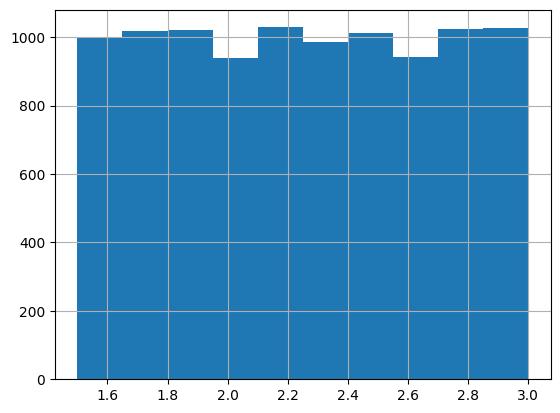

In [8]:
data[1].hist()

In [5]:
SEED = 42
train_intervals_df, test_intervals_df = train_test_split(data, train_size=0.8, random_state=SEED, shuffle=True)

In [6]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [7]:
train_intervals_X = np.array(train_intervals_df)[:, 2:]
train_intervals_Y = np.array(train_intervals_df)[:, :2]
test_intervals_X = np.array(test_intervals_df)[:, 2:]
test_intervals_Y = np.array(test_intervals_df)[:, :2]
val_intervals_X = np.array(val_intervals_df)[:, 2:]
val_intervals_Y = np.array(val_intervals_df)[:, :2]

### МНК


In [13]:
def estimate_parameters_lsq(sample):
    # Сортировка выборки и вычисление эмпирической ФРС
    sample_sorted = np.sort(sample)
    ecdf = np.arange(1, len(sample) + 1) / len(sample)
    
    def fisher_cdf(x, dfn, dfd):
        """
        Кумулятивная функция распределения Фишера (Fisher-Snedecor).
        dfn - степени свободы числителя,
        dfd - степени свободы знаменателя.
        """
        return f.cdf(x, dfn, dfd)
    
    def error_function(params, x, ecdf_values):
        """
        Функция ошибки – сумма квадратов разностей между
        теоретической ФРС, полученной для параметров dfn и dfd,
        и эмпирической ФРС.
        """
        dfn, dfd = params
        # Ограничения на параметры: степени свободы должны быть положительны
        #if dfn <= 0 or dfd <= 0:
        #    return 1e10  # штрафное большое значение ошибки
        theoretical_cdf = fisher_cdf(x, dfn, dfd)
        return np.sum((theoretical_cdf - ecdf_values) ** 2)
    
    # Начальные предположения для степеней свободы
    initial_guess = [0.7, 3]
    
    # Оптимизация для минимизации функции ошибки
    result = optimize.minimize(
        error_function,
        initial_guess,
        args=(sample_sorted, ecdf),
        bounds=[(1e-10, None), (1e-10, None)]  # dfn > 0, dfd > 0
    )
    
    return result.x

In [22]:
estimate_parameters_lsq(test_intervals_X[:1,:][0])

array([0.91714497, 1.50148138])

In [23]:
test_intervals_Y

array([[0.92527419, 1.55539069],
       [0.40299768, 2.42167129],
       [0.83282544, 2.90862349],
       ...,
       [0.31878658, 2.08372728],
       [0.34064747, 1.95872789],
       [0.21779591, 1.91144715]])

In [14]:
mnk = np.zeros((2000,2))
#mnk = np.zeros((test_Y.shape[0], test_Y.shape[1]))
for i, sample in enumerate(train_intervals_X[:1,:]):
    print(i, sample)
    mnk[i, 0], mnk[i, 1] = estimate_parameters_lsq(sample)

0 [1.62650364e-12 7.14088226e-03 2.70531293e+01 ... 3.38622840e-04
 8.40550572e-04 1.19757424e-09]


In [ ]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - mnk[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], mnk[:,0])
mse = mean_squared_error(test_Y[:,0], mnk[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], mnk[:,0]))
print("\nd1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - mnk[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], mnk[:,1])
mse = mean_squared_error(test_Y[:,1], mnk[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], mnk[:,1]))
print("\nd2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


d1
MSE: 8.099390124615442e-05
RMSE: 0.008999661173963964
R² Score: 0.9990078367922457
MAPE: 1.1483590846745357%

d2
MSE: 46.76721500999632
RMSE: 6.838655935927492
R² Score: -246.79565290528717
MAPE: 23.668397246805004%


### Регрессия на интервалах

In [ ]:
phisher_inter = CatBoostRegressor(loss_function='MultiRMSE')
phisher_inter.fit(train_X, train_Y, eval_set = (test_X, test_Y))

0:	learn: 0.5172029	test: 0.5174096	best: 0.5174096 (0)	total: 2.78s	remaining: 46m 14s
1:	learn: 0.5145446	test: 0.5148435	best: 0.5148435 (1)	total: 5.36s	remaining: 44m 32s
2:	learn: 0.5120202	test: 0.5123282	best: 0.5123282 (2)	total: 8.12s	remaining: 44m 57s
3:	learn: 0.5095622	test: 0.5099125	best: 0.5099125 (3)	total: 10.6s	remaining: 44m 11s
4:	learn: 0.5072400	test: 0.5076348	best: 0.5076348 (4)	total: 13.2s	remaining: 43m 41s
5:	learn: 0.5049084	test: 0.5054530	best: 0.5054530 (5)	total: 15.8s	remaining: 43m 44s
6:	learn: 0.5026750	test: 0.5033294	best: 0.5033294 (6)	total: 18.4s	remaining: 43m 25s
7:	learn: 0.5005217	test: 0.5012864	best: 0.5012864 (7)	total: 21s	remaining: 43m 24s
8:	learn: 0.4984411	test: 0.4992886	best: 0.4992886 (8)	total: 23.5s	remaining: 43m 3s
9:	learn: 0.4964433	test: 0.4973557	best: 0.4973557 (9)	total: 25.9s	remaining: 42m 41s
10:	learn: 0.4944441	test: 0.4954553	best: 0.4954553 (10)	total: 29.7s	remaining: 44m 33s
11:	learn: 0.4925802	test: 0.4936

In [ ]:
Cat_predictions = phisher_inter.predict(test_X)

In [ ]:
phisher_inter.save_model('phisher_inter_model.cbm')

In [ ]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nInter par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')
#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nInter par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')



Inter par 1
MSE: 0.0063781112901406005
RMSE: 0.07986307839133551
R² Score: 0.9218690881698879
MAPE: 17.91475359367088%

Inter par 2
MSE: 0.09308826663120087
RMSE: 0.30510369816047933
R² Score: 0.5067726867471279
MAPE: 12.136215790999282%


### Регрессия на статистиках

In [ ]:
stat_M = np.zeros((7999,10)) # Матрицы для записиси статистик наблюдений
test_stat_M = np.zeros((2000,10))

In [ ]:
#Далее для каждого наблюдения вычисляются 4 статистики
stat_M[:,0] = np.mean(train_X, axis=1) # Вычисляется среднее 
stat_M[:,1] = np.var(train_X, axis=1) # Вычисляется дисперсию 
stat_M[:,2] = np.std(train_X, axis=1) # Вычисляется стандартное отклонение
stat_M[:,3] =  stat_M[:,2] / stat_M[:,0] # Вычисляется вариацию 

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    stat_M[:, 4 + i] = np.quantile(train_X, q, axis=1)

In [ ]:
test_stat_M[:,0] = np.mean(test_X, axis=1)
test_stat_M[:,1] = np.var(test_X, axis=1)
test_stat_M[:,2] = np.std(test_X, axis=1)
test_stat_M[:,3] =  test_stat_M[:,2] / test_stat_M[:,0]

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    test_stat_M[:, 4 + i] = np.quantile(test_X, q, axis=1)

In [ ]:
phisher_stat = CatBoostRegressor(iterations=10000,
                          learning_rate=0.05,
                          depth=5, loss_function='MultiRMSE')
phisher_stat.fit(stat_M, train_Y, eval_set = (test_stat_M, test_Y))

0:	learn: 0.4983587	test: 0.4983616	best: 0.4983616 (0)	total: 17.1ms	remaining: 2m 51s
1:	learn: 0.4789741	test: 0.4790342	best: 0.4790342 (1)	total: 22.9ms	remaining: 1m 54s
2:	learn: 0.4600690	test: 0.4602308	best: 0.4602308 (2)	total: 28.8ms	remaining: 1m 36s
3:	learn: 0.4416682	test: 0.4418330	best: 0.4418330 (3)	total: 33.2ms	remaining: 1m 22s
4:	learn: 0.4245548	test: 0.4247790	best: 0.4247790 (4)	total: 37.9ms	remaining: 1m 15s
5:	learn: 0.4086418	test: 0.4089532	best: 0.4089532 (5)	total: 43.1ms	remaining: 1m 11s
6:	learn: 0.3925615	test: 0.3931333	best: 0.3931333 (6)	total: 50.8ms	remaining: 1m 12s
7:	learn: 0.3770959	test: 0.3778586	best: 0.3778586 (7)	total: 55.6ms	remaining: 1m 9s
8:	learn: 0.3631662	test: 0.3640332	best: 0.3640332 (8)	total: 59.5ms	remaining: 1m 6s
9:	learn: 0.3496602	test: 0.3506320	best: 0.3506320 (9)	total: 62.7ms	remaining: 1m 2s
10:	learn: 0.3368682	test: 0.3379018	best: 0.3379018 (10)	total: 73.5ms	remaining: 1m 6s
11:	learn: 0.3248290	test: 0.32591

In [ ]:
Cat_predictions = phisher_stat.predict(test_stat_M)

In [ ]:
phisher_stat.save_model('phisher_stat_model.cbm')

In [ ]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nStat par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nStat par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Stat par 1
MSE: 0.00016999692312056675
RMSE: 0.013038286816931385
R² Score: 0.9979175630515801
MAPE: 3.0379817201132013%

Stat par 2
MSE: 0.009216531394477248
RMSE: 0.09600276763967405
R² Score: 0.9511662942955144
MAPE: 2.9716189231795984%


### Регрессия на моментах

In [ ]:
train_m_X = train_X.copy()
for i in range(train_X.shape[0]):
    for j in range(1, train_X.shape[1]):
        train_m_X[i,j] += train_m_X[i,j-1]

test_m_X = test_X.copy()
for i in range(test_X.shape[0]):
    for j in range(1, test_X.shape[1]):
        test_m_X[i,j] += test_m_X[i,j-1]

In [ ]:
phisher_m = CatBoostRegressor(loss_function='MultiRMSE')
phisher_m.fit(train_m_X, train_Y, eval_set = (test_m_X, test_Y))

0:	learn: 0.5098534	test: 0.5101204	best: 0.5101204 (0)	total: 2.72s	remaining: 45m 13s
1:	learn: 0.5006709	test: 0.5011325	best: 0.5011325 (1)	total: 5.42s	remaining: 45m 2s
2:	learn: 0.4914465	test: 0.4919641	best: 0.4919641 (2)	total: 8.37s	remaining: 46m 20s
3:	learn: 0.4824999	test: 0.4831469	best: 0.4831469 (3)	total: 11.3s	remaining: 46m 55s
4:	learn: 0.4745486	test: 0.4753807	best: 0.4753807 (4)	total: 14.3s	remaining: 47m 29s
5:	learn: 0.4665224	test: 0.4674579	best: 0.4674579 (5)	total: 17.2s	remaining: 47m 27s
6:	learn: 0.4589175	test: 0.4599806	best: 0.4599806 (6)	total: 20s	remaining: 47m 24s
7:	learn: 0.4512827	test: 0.4524759	best: 0.4524759 (7)	total: 22.8s	remaining: 47m 3s
8:	learn: 0.4439240	test: 0.4452967	best: 0.4452967 (8)	total: 25.7s	remaining: 47m 7s
9:	learn: 0.4369799	test: 0.4384006	best: 0.4384006 (9)	total: 28.3s	remaining: 46m 44s
10:	learn: 0.4300380	test: 0.4316137	best: 0.4316137 (10)	total: 31s	remaining: 46m 24s
11:	learn: 0.4234548	test: 0.4252081	

In [ ]:
Cat_predictions = phisher_m.predict(test_X)

In [ ]:
phisher_m.save_model('phisher_moment_model.cbm')

In [ ]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nMoment par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nMoment par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Moment par 1
MSE: 0.26843738821157875
RMSE: 0.5181094365204891
R² Score: -2.2883179606297053
MAPE: 84.91909281300332%

Moment par 2
MSE: 0.47857068798845653
RMSE: 0.6917880368931343
R² Score: -1.5357023304912292
MAPE: 29.904147542312877%
